In [1]:
import pandas as pd
from scipy.special import binom
from tqdm import tqdm
from itertools import combinations
from pathlib import Path
from collections import defaultdict

import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)
import numpy as np
import matplotlib.pyplot as plt

get_ipython().run_line_magic("matplotlib", "inline")
font = {"weight": "normal", "size": 14, "family": "DejaVu Sans"}
plt.rc("text", usetex=True)
plt.rc("font", **font)


def rec_dd():
    return defaultdict(rec_dd)


In [2]:
benchmark_path = Path(
    "/home/gabrielathenes/Documents/study/HILARy/data_with_scripts/benchmark_on_partis_dataset"
)
hilary_full="hilary-full-1-2-0"
hilary_cdr3="hilary-cdr3-1-2-0"


In [3]:
def pairwise_evaluation(df, partition, ground_truth="simulations"):
    TP = 0
    P = binom(df.groupby([ground_truth]).size(), 2).sum()
    TP_FP = binom(df.groupby([partition]).size(), 2).sum()
    for _, family in tqdm(df.groupby([ground_truth]), disable=True):
        for r1, r2 in combinations(family[partition], 2):
            if r1 == r2:
                TP += 1
    if TP_FP == 0:
        return 0.0, 1.0
    elif P == 0:
        return None, None
    return (
        TP / P,
        TP / TP_FP,
    )  # sensitivity, precision

def entropy(dfGrouped):
    fs = dfGrouped.size()
    fs = fs / sum(fs)
    return sum(fs * np.log2(fs))


def variation_of_info(df, result):
    VI = (
        entropy(df.groupby(["simulations"]))
        + entropy(df.groupby([result]))
        - 2 * entropy(df.groupby([result, "simulations"]))
    )
    return VI


In [4]:
metric_dict=rec_dd()
for seed in [0, 1, 2]:
    print(seed)
    prec_list=[]
    sens_list=[]
    var_list=[]
    dataframe=pd.DataFrame()
    for model in ["simulations","partis","scoper","alignment_free",hilary_full,hilary_cdr3]:
        print(model)
        if model.startswith("alignment"):
            df = pd.read_csv(
                [
                    each
                    for each in (
                        benchmark_path
                        / Path(
                            f"seed-{seed}/scratch-mute-freq-0.10/{model}/single_chain/"
                        )
                    ).glob(f"*igh.tsv")
                ][0],
                sep=",",
                index_col="sequence_id",
            )
        else :
            df = pd.read_csv(
            [
                each
                for each in (benchmark_path
                / Path(
                    f"seed-{seed}/scratch-mute-freq-0.10/{model}/single_chain/"
                )).glob(f"*igh.tsv")
            ][0],
            sep="\t",
            index_col="sequence_id",
            )

        if model.startswith("hilary-full"):
            dataframe[model]=df["family"]
            dataframe["cdr3_length"]=df["cdr3_length"]
        elif model.startswith("hilary-cdr3"):
            dataframe[model]=df["cdr3_based_family"]
        elif model.startswith("alignment"):
            dataframe[model] = df["CLONE"]
        else :
            dataframe[model]=df["clone_id"]
        if model=="simulations":
            dataframe["v_gene"]=df["v_call"].apply(lambda x: x.split("*")[0])
            dataframe["j_gene"] = df["j_call"].apply(lambda x: x.split("*")[0])

    grouped=dataframe.groupby("cdr3_length")
    for l,df_grouped in grouped :
        if l>45:continue
        prevalence = (
            binom(
                df_grouped.groupby(["v_gene", "j_gene", "simulations"]).size(), 2
            ).sum()
            / binom(df_grouped.groupby(["v_gene", "j_gene"]).size(), 2).sum()
        )
        metric_dict["prevalence"][l][seed] = prevalence
        for model in ["partis","scoper",hilary_full,hilary_cdr3,"alignment_free"]:
            sensitivity,precision=pairwise_evaluation(df_grouped,model)
            varinfo = variation_of_info(df_grouped,model)
            metric_dict[model]["precision"][l][seed]=precision
            metric_dict[model]["sensitivity"][l][seed]=sensitivity
            metric_dict[model]["variation_of_info"][l][seed]=varinfo


0
simulations
partis


/tmp/ipykernel_1610438/1718582547.py:25: DtypeWarning: Columns (2,3,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


scoper
alignment_free
hilary-full-1-2-0
hilary-cdr3-1-2-0
1
simulations
partis


/tmp/ipykernel_1610438/1718582547.py:25: DtypeWarning: Columns (2,3,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


scoper
alignment_free
hilary-full-1-2-0
hilary-cdr3-1-2-0
2
simulations
partis


/tmp/ipykernel_1610438/1718582547.py:25: DtypeWarning: Columns (2,3,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


scoper
alignment_free
hilary-full-1-2-0
hilary-cdr3-1-2-0


### With prevalence

scoper
SCOPer
hilary-cdr3-1-2-0
HILARy-CDR3
hilary-full-1-2-0
HILARy-full
HILARy-full
partis
partis
alignment_free
Alignment-free


/tmp/ipykernel_1610438/2706266218.py:73: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(1.2)


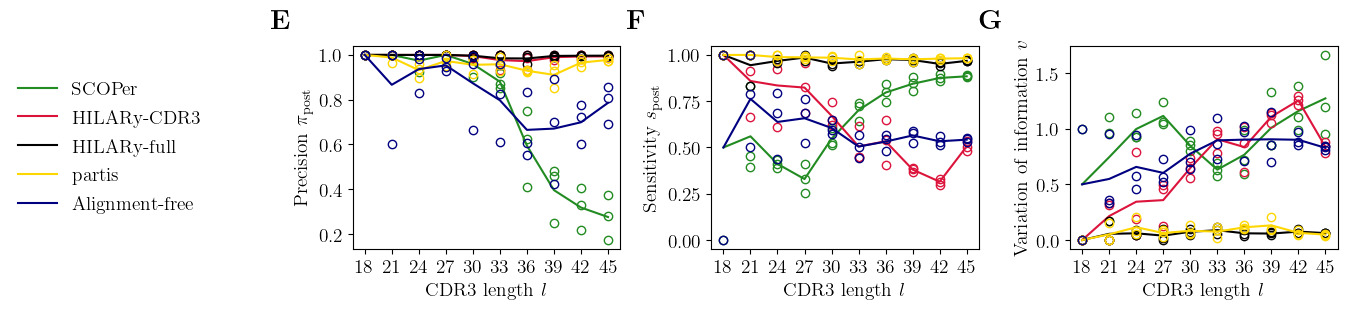

In [21]:
ls = np.arange(18, 45 + 3, 3)
fig = plt.figure(figsize=(14, 3))
ax1 = fig.add_subplot(131)
ax1.set_ylabel(r"Precision $\pi_{\rm post}$")
ax1.set_xlabel(r"CDR3 length $l$")
ax2 = fig.add_subplot(132)
ax2.set_ylabel(r"Sensitivity $s_{\rm post}$")
ax2.set_xlabel(r"CDR3 length $l$")
ax3 = fig.add_subplot(133)
ax3.set_ylabel(r"Variation of information $v$")
ax3.set_xlabel(r"CDR3 length $l$")

colors = {
    "scoper": "forestgreen",
    hilary_cdr3: "crimson",
    hilary_full: "k",
    "partis": "gold",
    "alignment_free":"navy",
}
axes = [ax1, ax2, ax3]


for model in colors:
    print(model)
    if model == hilary_full:
        label = "HILARy-full"
        print(label)
    elif model == hilary_cdr3:
        label = "HILARy-CDR3"
    elif model == "alignment_free":
        label = "Alignment-free"
    elif model =="partis":
        label="partis"
    elif model=="scoper":
        label = "SCOPer"
    else:
        label = model
    print(label)
    for i, metric in enumerate(metric_dict[model]):
        for l in metric_dict[model][metric]:
            if l==15:
                continue
            y = list(metric_dict[model][metric][l].values())
            x = [l] * len(y)
            axes[i].plot(
                x,
                y,
                "o",
                fillstyle="none",
                color=colors[model],
            )
        lengths = []
        averages = []
        for length in metric_dict[model][metric]:
            lengths.append(length)
            averages.append(np.mean(list(metric_dict[model][metric][length].values())))
        axes[i].plot(
            lengths,
            averages,
            color=colors[model],
            label=label,
        )


ax1.set_xticks(ls)
ax1.set_xticklabels(ls)
ax2.set_xticks(ls)
ax2.set_xticklabels(ls)
ax3.set_xticks(ls)
ax3.set_xticklabels(ls)
ax1.legend(bbox_to_anchor=(-2.8, 0.12, 2.3, 0.8), frameon=False)

plt.tight_layout(1.2)
plt.text(-72, 1.9, r"\bf{E}", rotation=0, wrap=True, fontsize=20)
plt.text(-32.5, 1.9, r"\bf{F}", rotation=0, wrap=True, fontsize=20)
plt.text(6.5, 1.9, r"\bf{G}", rotation=0, wrap=True, fontsize=20)
plt.savefig(
    "/home/gabrielathenes/Dropbox/Natanael_lineages_inference/revisions_2024_01_26/figures/figure4_partis.png",
    bbox_inches="tight",
)
plt.show()
